# Movielens 영화 추천 실습

MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

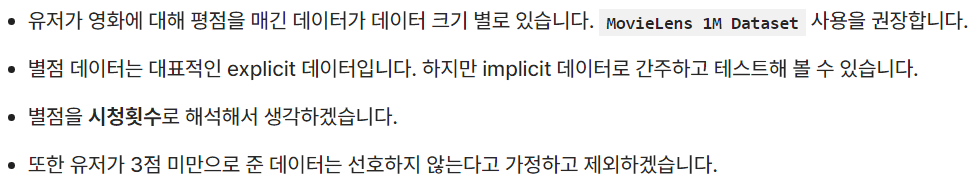

Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.

In [1]:
!mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
!ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m

ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/movies.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/ratings.dat': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/README': File exists
ln: failed to create symbolic link '/aiffel/aiffel/recommendata_iu/data/ml-1m/users.dat': File exists


In [2]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


1) 데이터 준비와 전처리

In [3]:
import pandas as pd
import os

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)    # 원본데이터 길이

ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)    # 전처리한 데이터 길이

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [5]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)

In [6]:
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')

movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


2) 데이터 분석

ratings에 있는 유니크한 영화 개수, ratings에 있는 유니크한 사용자 수, 가장 인기 있는 영화 30개(인기순)

In [8]:
# 유니크한 영화 개수
ratings['movie_id'].nunique()

3628

In [9]:
# 유니크한 사용자 수
ratings['user_id'].nunique()

6039

In [10]:
# 가장 인기 있는 영화 30개
movies_count = ratings.groupby('movie_id')['user_id'].count()

movies_count.sort_values(ascending=False).head(30)

movie_id
2858    3211
260     2910
1196    2885
1210    2716
2028    2561
589     2509
593     2498
1198    2473
1270    2460
2571    2434
480     2413
2762    2385
608     2371
110     2314
1580    2297
527     2257
1197    2252
2396    2213
1617    2210
318     2194
858     2167
1265    2121
1097    2102
2997    2066
2716    2051
296     2030
356     2022
1240    2019
1       2000
457     1941
Name: user_id, dtype: int64

3) 내가 선호하는 영화를 5가지 골라서 rating에 추가해 줍시다.

In [11]:
movies['title']

0                         Toy Story (1995)
1                           Jumanji (1995)
2                  Grumpier Old Men (1995)
3                 Waiting to Exhale (1995)
4       Father of the Bride Part II (1995)
                       ...                
3878               Meet the Parents (2000)
3879            Requiem for a Dream (2000)
3880                      Tigerland (2000)
3881               Two Family House (2000)
3882                 Contender, The (2000)
Name: title, Length: 3883, dtype: object

In [12]:
# 내가 선호하는 영화 5개
my_favorite = ['Toy Story (1995)' , 'Jerry & Tom (1998)' ,'Sound of Music, The (1965)' ,'Jumanji (1995)' ,'Titanic (1997)']

for i in range(5):
    temp = movies[movies['title'] == my_favorite[i]]
    print(temp)

   movie_id             title                        genre
0         1  Toy Story (1995)  Animation|Children's|Comedy
      movie_id               title  genre
3806      3876  Jerry & Tom (1998)  Drama
      movie_id                       title    genre
1022      1035  Sound of Music, The (1965)  Musical
   movie_id           title                         genre
1         2  Jumanji (1995)  Adventure|Children's|Fantasy
      movie_id           title          genre
1672      1721  Titanic (1997)  Drama|Romance


In [13]:
my_favorite = [0, 3806, 1022, 1, 1672]
my_count = [5.0, 4.0, 5.0, 3.0, 4.0]
my_movielist = pd.DataFrame({'user_id': ['sehui']*5, 'movie_id': my_favorite, 'count': my_count})

if not ratings.isin({'user_id':['sehui']})['user_id'].any():  # user_id에 'sehui'이라는 데이터가 없다면
    ratings = ratings.append(my_movielist)                           # 위에 임의로 만든 my_movielist 데이터를 추가해 줍니다. 

ratings.tail(10)

,user_id,movie_id,count,timestamp
1000203,6040,1090,3.0,956715518.0
1000205,6040,1094,5.0,956704887.0
1000206,6040,562,5.0,956704746.0
1000207,6040,1096,4.0,956715648.0
1000208,6040,1097,4.0,956715569.0
0,sehui,0,5.0,NaN
1,sehui,3806,4.0,NaN
2,sehui,1022,5.0,NaN
3,sehui,1,3.0,NaN
4,sehui,1672,4.0,NaN


추가적인 전처리 (indexing, 칼럼제거)

In [14]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
movie_unique = ratings['movie_id'].unique()

# 유저, 영화를 indexing 하는 코드
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [15]:
user_unique

array([1, 2, 3, ..., 6039, 6040, 'sehui'], dtype=object)

In [16]:
user_to_idx['sehui']

6039

In [17]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

temp_user_data = ratings['user_id'].map(user_to_idx).dropna()
if len(temp_user_data) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = ratings['movie_id'].map(movie_to_idx).dropna()
if len(temp_movie_data) == len(ratings):
    print('movie_id column indexing OK!!')
    ratings['movie_id'] = temp_movie_data
else:
    print('artist column indexing Fail!!')

ratings

user_id column indexing OK!!
movie_id column indexing OK!!


,user_id,movie_id,count,timestamp
0,0,0,5.0,978300760.0
1,0,1,3.0,978302109.0
2,0,2,3.0,978301968.0
3,0,3,4.0,978300275.0
4,0,4,5.0,978824291.0
...,...,...,...,...
0,6039,3628,5.0,NaN
1,6039,2168,4.0,NaN
2,6039,37,5.0,NaN
3,6039,40,3.0,NaN


4) CSR matrix를 직접 만들어 봅시다.

In [18]:
ratings['count']

0    5.0
1    3.0
2    3.0
3    4.0
4    5.0
    ... 
0    5.0
1    4.0
2    5.0
3    3.0
4    4.0
Name: count, Length: 836483, dtype: float64

In [19]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3629 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Row format>

5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

In [20]:

from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 설정. 학습내용과 무관.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터

factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지, 
regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지, 
use_gpu : GPU를 사용할 것인지, 
iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지, 

파라미터 factors와 iterations를 늘릴수록 학습데이터를 잘 학습하게 되지만 overfitting의 우려가 있으니 좋은 값을 찾아야 한다.

In [21]:
# Implicit AlternatingLeastSquares 모델의 선언

als_model = AlternatingLeastSquares(factors=640, regularization=0.01, use_gpu=False, iterations=30, dtype=np.float64)

In [22]:

# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose


<3629x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [23]:
# 모델 훈련
als_model.fit(csr_data_transpose)


  0%|          | 0/30 [00:00<?, ?it/s]

6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [24]:
sehui, little_mermaid = user_to_idx['sehui'], movie_to_idx[2081]
sehui_vector, little_mermaid_vector = als_model.user_factors[sehui], als_model.item_factors[little_mermaid]

In [25]:
print(sehui_vector.shape)
print(little_mermaid_vector.shape)

(640,)
(640,)


In [26]:
np.dot(sehui_vector, little_mermaid_vector)

0.036377528979308744

In [27]:
jumanji_vector = als_model.item_factors[movie_to_idx[2]]    # 영화 jumanji
np.dot(sehui_vector, jumanji_vector)

0.0021416156116257565

In [28]:
toystory_vector = als_model.item_factors[movie_to_idx[1]]    # 영화 toystory
np.dot(sehui_vector, toystory_vector)

0.9179208324919674

In [29]:
Tarzan_vector = als_model.item_factors[movie_to_idx[2]]    # 영화 Tarzan
np.dot(sehui_vector, jumanji_vector)

0.0021416156116257565

7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [30]:
movie_id = movie_to_idx[2523]   
similar_movie = als_model.similar_items(movie_id, N=15)

similar_movie


[(3073, 1.0000000000000002),
 (3552, 0.8957136610667901),
 (3551, 0.8956615475959496),
 (2808, 0.8920699333893995),
 (3526, 0.8905800582957246),
 (3521, 0.8894071566466885),
 (3555, 0.889116076009806),
 (3570, 0.8886597893612478),
 (1742, 0.8875231421346712),
 (3370, 0.8874994646311051),
 (3610, 0.8872181162191115),
 (3628, 0.886915768006067),
 (3496, 0.8868051738274432),
 (2929, 0.8867344613640358),
 (3534, 0.8867335006735751)]

In [31]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

[2523,
 311,
 572,
 3573,
 2234,
 1495,
 2623,
 1107,
 1861,
 3294,
 2543,
 0,
 1915,
 2754,
 3779]

In [32]:
def get_similar_movie(movie_id: str):
    movie_id = movie_to_idx[movie_id]
    similar_movie = als_model.similar_items(movie_id, N=20)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [33]:
movie_list = get_similar_movie(1)

movie_list

[1,
 0,
 106,
 1324,
 3290,
 3303,
 3026,
 690,
 1843,
 3899,
 2909,
 1871,
 460,
 3482,
 3876,
 657,
 1868,
 1315,
 3601,
 2869]

In [34]:
movies.loc[movies['movie_id'].isin(movie_list)]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
104,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama
456,460,Getting Even with Dad (1994),Comedy
651,657,Yankee Zulu (1994),Comedy|Drama
681,690,"Promise, The (Versprechen, Das) (1994)",Romance
1295,1315,Paris Was a Woman (1995),Documentary
1304,1324,Amityville: Dollhouse (1996),Horror
1774,1843,Slappy and the Stinkers (1998),Children's|Comedy
1799,1868,"Truce, The (1996)",Drama|War
1802,1871,"Friend of the Deceased, A (1997)",Comedy|Drama


8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [35]:
user = user_to_idx['sehui']

# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(572, 0.2745608162611099),
 (551, 0.21066202742843504),
 (8, 0.19379888259761197),
 (330, 0.1791176009427498),
 (46, 0.17260356220950412),
 (17, 0.14735241492791418),
 (1566, 0.13609707572819904),
 (10, 0.12328588469959918),
 (2189, 0.12192235504090065),
 (285, 0.11720092566646768),
 (924, 0.11481771567514591),
 (619, 0.11432976991540815),
 (829, 0.11061238280712164),
 (655, 0.10846828909683162),
 (1216, 0.10702735197936603),
 (462, 0.10282610100495915),
 (968, 0.10077711212662135),
 (838, 0.09986124028298177),
 (710, 0.09895527497759439),
 (503, 0.09887640259502364)]

In [36]:
movie_list = [idx_to_movie[i[0]] for i in movie_recommended]

movie_list

[2096,
 2087,
 594,
 364,
 1029,
 2018,
 3873,
 595,
 3792,
 1513,
 1748,
 1032,
 2433,
 1204,
 350,
 805,
 1960,
 1804,
 2617,
 1256]

In [37]:

movies.loc[movies['movie_id'].isin(movie_list)]

,movie_id,title,genre
346,350,"Client, The (1994)",Drama|Mystery|Thriller
360,364,"Lion King, The (1994)",Animation|Children's|Musical
590,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
591,595,Beauty and the Beast (1991),Animation|Children's|Musical
795,805,"Time to Kill, A (1996)",Drama
1016,1029,Dumbo (1941),Animation|Children's|Musical
1019,1032,Alice in Wonderland (1951),Animation|Children's|Musical
1186,1204,Lawrence of Arabia (1962),Adventure|War
1236,1256,Duck Soup (1933),Comedy|War
1478,1513,Romy and Michele's High School Reunion (1997),Comedy


user데이터가 추천에 기여한 정도 확인

In [38]:
movie_idx = movie_to_idx[2096]    # 잠자는 숲속의 미녀
explain = als_model.explain(user, csr_data, itemid=movie_idx)

In [39]:
[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[(1022, 0.25189157941525064),
 (1, 0.009162924406800482),
 (1672, 0.007159412157768576),
 (3806, 0.0034598047311633715),
 (0, -0.0011332340271618432)]

In [40]:
movie_list = [idx_to_movie[i[0]] for i in explain[1]]
movies.loc[movies['movie_id'].isin(movie_list)]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1009,1022,Cinderella (1950),Animation|Children's|Musical
1626,1672,"Rainmaker, The (1997)",Drama
3737,3806,MacKenna's Gold (1969),Western
